In [9]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Auto Encoder for Dimensionality Reduction

In [10]:
import lightning as L
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchmetrics import MeanSquaredError
from torchvision import datasets
from utils.helper_classes import CancerDataModule, CancerDataset
from utils.models import CancerDataAutoEncoder

In [11]:
# np.random.seed(42)

# # Parameters
# num_samples = 2621
# num_genes = 1800

# # Base clinical data
# clinical_data = {
#     "PatientID": [f"PID_{i}" for i in range(1, num_samples + 1)],
#     "CopyNumberVariant": np.random.randint(0, 10, size=num_samples),
#     "SmokingStatus": np.random.choice([1, 0], size=num_samples),
#     "OverallSurvivalMonths": np.random.uniform(6, 60, size=num_samples).round(2),
# }

# # Simulated gene mutation matrix: binary (0=wildtype, 1=mutated)
# mutation_matrix = np.random.choice([0, 1], size=(num_samples, num_genes), p=[0.97, 0.03])

# # Gene column names
# gene_cols = [f"Gene_{i+1}" for i in range(num_genes)]
# mutation_df = pd.DataFrame(mutation_matrix, columns=gene_cols, index=clinical_data["PatientID"])

# # Combine all data
# cancer_df = pd.concat([pd.DataFrame(clinical_data).set_index("PatientID"), mutation_df], axis=1)

# # Preview
# print(cancer_df.iloc[:, :10].head())  # Just print first 10 columns to avoid overload


In [12]:
cancer_df = pd.read_csv("../data/cleaned_feature_and_target_data_large.csv", index_col=0)
cancer_df

,SMOKING_PACK_YEARS,SMOKING_HISTORY_Current Reformed Smoker For < Or = 15 Years,SMOKING_HISTORY_Current Reformed Smoker For > 15 Years,"SMOKING_HISTORY_Current Reformed Smoker, Duration Not Specified",SMOKING_HISTORY_Current Smoker,SMOKING_HISTORY_Lifelong Non-Smoker,ONCOTREE_CODE_LUAD,ONCOTREE_CODE_LUSC,ABCA13,ABCA9,...,CNA_COL4A5,CNA_DCAF12L2,CNA_DCAF12L1,CNA_GPR112,CNA_MAGEC1,CNA_SLITRK2,CNA_AFF2,CNA_FLNA,CNA_F8,OS_MONTHS
TCGA-33-AASD-01A-11D-A401-08,84.000000,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,111.05
TCGA-33-AASL-01A-11D-A401-08,60.000000,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,27.17
TCGA-NK-A7XE-01A-12D-A401-08,80.000000,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0,0,...,1,1,1,1,1,1,1,1,1,0.43
TCGA-XC-AA0X-01A-32D-A401-08,30.000000,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0,0,...,0,0,0,0,0,0,0,0,0,0.20
TCGA-33-AASI-01A-22D-A401-08,60.000000,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0,1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,44.21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-44-6775-01A-11D-1855-08,25.000000,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,...,0,0,0,0,0,0,0,0,0,2.70
TCGA-44-6146-01A-11D-1753-08,15.000000,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,9.90
TCGA-44-6147-01A-11D-1753-08,35.489939,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0,0,...,0,0,0,0,0,0,0,0,0,7.80
TCGA-44-2662-01A-01D-0969-08,56.000000,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1,0,...,0,0,0,0,0,0,0,0,0,15.80


In [13]:
cancer_ds = CancerDataset(cancer_df)
cancer_ds[0][0].shape

torch.Size([989])

In [14]:
cna_columns = [col for col in cancer_df.columns if col.startswith("CNA")]
numeric_cols = ["SMOKING_PACK_YEARS"] + cna_columns
cancer_df[numeric_cols] = cancer_df[numeric_cols].astype(np.float32)


In [15]:
cancer_dm = CancerDataModule(cancer_df, numerical_features=numeric_cols)
cancer_dm.setup()

In [16]:
len(cancer_dm.ds_train), len(cancer_dm.ds_val), len(cancer_dm.ds_test)

(558, 186, 187)

In [17]:
#first batch from cancer_dm
batch = next(iter(cancer_dm.train_dataloader()))
batch[0].shape, batch[1].shape

(torch.Size([32, 989]), torch.Size([32, 1]))

In [18]:
from torchinfo import summary

input_dim = len(cancer_dm.ds_train[0][0])
summary(CancerDataAutoEncoder(input_size=input_dim, latent_size=20), input_size=(32, input_dim))

Layer (type:depth-idx)                   Output Shape              Param #
CancerDataAutoEncoder                    [32, 989]                 --
├─Sequential: 1-1                        [32, 20]                  --
│    └─Linear: 2-1                       [32, 666]                 659,340
│    └─ReLU: 2-2                         [32, 666]                 --
│    └─Dropout: 2-3                      [32, 666]                 --
│    └─Linear: 2-4                       [32, 343]                 228,781
│    └─ReLU: 2-5                         [32, 343]                 --
│    └─Dropout: 2-6                      [32, 343]                 --
│    └─Linear: 2-7                       [32, 20]                  6,880
│    └─ReLU: 2-8                         [32, 20]                  --
│    └─Dropout: 2-9                      [32, 20]                  --
├─Sequential: 1-2                        [32, 989]                 --
│    └─Linear: 2-10                      [32, 343]                 7,203

In [19]:
from utils.helper_functions import create_classifier_trainer


trainer, ae_csv_logger, ae_checkpoint = create_classifier_trainer("cancer_auto_encoder")
cancer_ae = CancerDataAutoEncoder(input_size=len(cancer_dm.ds_train[0][0]), latent_size=20, n_layers=3, dropout=0.2)
trainer.fit(
    cancer_ae,
    datamodule=CancerDataModule(cancer_df, numerical_features=numeric_cols),
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | encoder     | Sequential       | 895 K  | train
1 | decoder     | Sequential       | 895 K  | train
2 | loss_metric | MeanSquaredError | 0      | train
3 | val_metric  | MeanSquaredError | 0      | train
4 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
1.8 M     Trainable params
0         N

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


In [20]:
trainer.test(cancer_ae, datamodule=cancer_dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.5215564370155334     │
│         test_mse          │    0.5215564370155334     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.5215564370155334, 'test_mse': 0.5215564370155334}]

In [21]:
def make_plots(history, title):
    plt.figure(figsize=(12, 5))
    plt.suptitle(title)
    train_history = history.dropna(subset=["train_loss"])
    val_history = history.dropna(subset=["val_loss"])
    # Loss Plot
    plt.plot(train_history["step"], train_history["train_loss"], label="Train Loss", marker="o")
    plt.plot(
        val_history["step"],
        val_history["val_loss"],
        label="Validation Loss",
        marker="o",
        linestyle="-",
    )
    plt.xlabel("step")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()


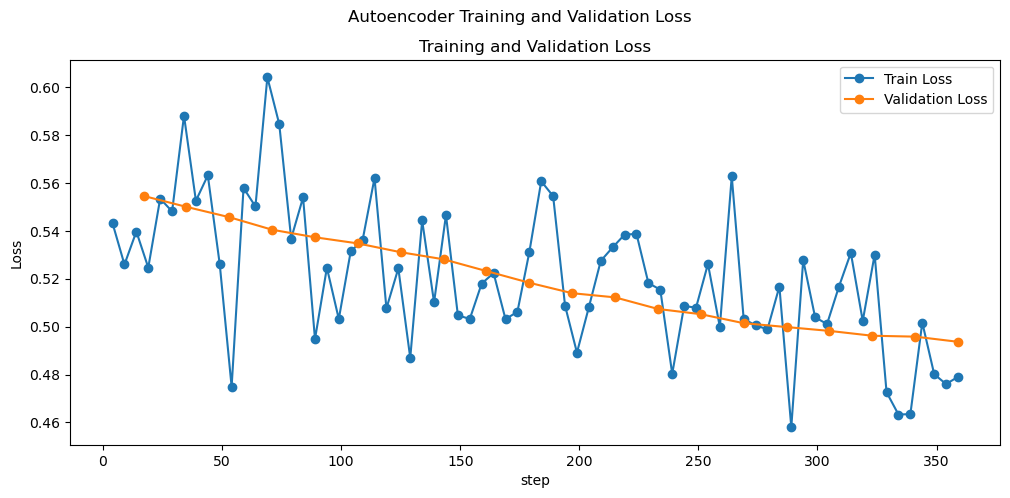

In [22]:
history = pd.read_csv(ae_csv_logger.log_dir + "/metrics.csv")

make_plots(history, "Autoencoder Training and Validation Loss")

In [ ]:
import optuna

trial_to_details = {}
def objective(trial):
    latent_size = trial.suggest_int("latent_size", 3, 50)
    n_layers = trial.suggest_int("n_layers", 1, 15)
    dropout = trial.suggest_float("dropout", 0.0, 0.5)
    input_dim = len(cancer_dm.ds_train[0][0])

    model = CancerDataAutoEncoder(
        input_size=input_dim,
        latent_size=latent_size,
        n_layers=n_layers,
        dropout=dropout,
    )
    trainer, logger, checkpoint = create_classifier_trainer(f"trial_{trial.number}", max_epochs=100, enable_pbar=False)


    trial_to_details[trial.number] = {
        "logger" : logger,
        "checkpoint" : checkpoint,
    }

    trainer.fit(model, datamodule=cancer_dm)

    # Load validation metrics from CSV logger
    metrics_path = f"{logger.log_dir}/metrics.csv"
    metrics_df = pd.read_csv(metrics_path)

    if "val_mse_epoch" not in metrics_df.columns:
        return float("inf")

    last_val = metrics_df["val_mse_epoch"].dropna().values[-1]
    return last_val

# --- Run Optuna ---
study = optuna.create_study(direction="minimize", study_name="autoencoder_study")
study.optimize(objective, n_trials=50, n_jobs=1,  show_progress_bar=True)

# --- Print Best Result ---
print("Best trial:")
print(f"  Value (val_mse): {study.best_trial.value}")
print("  Params:")
for key, val in study.best_trial.params.items():
    print(f"    {key}: {val}")

[I 2025-04-18 10:41:33,800] A new study created in memory with name: autoencoder_study


  0%|          | 0/50 [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | encoder     | Sequential       | 3.4 M  | train
1 | decoder     | Sequential       | 4.3 M  | train
2 | loss_metric | MeanSquaredError | 0      | train
3 | val_metric  | MeanSquaredError | 0      | train
4 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
7.7 M     Trainable params
0         Non-trainable params
7.7 M     Total params
30.605    Total estimated model params size (MB)
67        Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


[I 2025-04-18 10:42:10,049] Trial 0 finished with value: 0.5482251644134521 and parameters: {'latent_size': 33, 'n_layers': 10, 'dropout': 0.3222884255004711}. Best is trial 0 with value: 0.5482251644134521.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | encoder     | Sequential       | 498 K  | train
1 | decoder     | Sequential       | 1.5 M  | train
2 | loss_metric | MeanSquaredError | 0      | train
3 | val_metric  | MeanSquaredError | 0      | train
4 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
2.0 M     Trainable params
0         Non-trainable params
2.0 M     Total params
7.897     Total estimated model params size (MB)
19        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 10:43:26,896] Trial 1 finished with value: 0.4488535821437835 and parameters: {'latent_size': 8, 'n_layers': 2, 'dropout': 0.315448062161702}. Best is trial 1 with value: 0.4488535821437835.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | encoder     | Sequential       | 2.3 M  | train
1 | decoder     | Sequential       | 3.3 M  | train
2 | loss_metric | MeanSquaredError | 0      | train
3 | val_metric  | MeanSquaredError | 0      | train
4 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
5.6 M     Trainable params
0         Non-trainable params
5.6 M     Total params
22.252    Total estimated model params size (MB)
49        Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


[I 2025-04-18 10:44:26,266] Trial 2 finished with value: 0.4856902956962585 and parameters: {'latent_size': 22, 'n_layers': 7, 'dropout': 0.0006056490546730298}. Best is trial 1 with value: 0.4488535821437835.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | encoder     | Sequential       | 519 K  | train
1 | decoder     | Sequential       | 1.5 M  | train
2 | loss_metric | MeanSquaredError | 0      | train
3 | val_metric  | MeanSquaredError | 0      | train
4 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
2.0 M     Trainable params
0         Non-trainable params
2.0 M     Total params
8.061     Total estimated model params size (MB)
19        Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


[I 2025-04-18 10:46:10,185] Trial 3 finished with value: 0.3419255316257477 and parameters: {'latent_size': 28, 'n_layers': 2, 'dropout': 0.10740297995081638}. Best is trial 3 with value: 0.3419255316257477.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | encoder     | Sequential       | 517 K  | train
1 | decoder     | Sequential       | 1.5 M  | train
2 | loss_metric | MeanSquaredError | 0      | train
3 | val_metric  | MeanSquaredError | 0      | train
4 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
2.0 M     Trainable params
0         Non-trainable params
2.0 M     Total params
8.044     Total estimated model params size (MB)
19        Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


[I 2025-04-18 10:48:09,657] Trial 4 finished with value: 0.3662402629852295 and parameters: {'latent_size': 26, 'n_layers': 2, 'dropout': 0.21106531362852488}. Best is trial 3 with value: 0.3419255316257477.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | encoder     | Sequential       | 3.4 M  | train
1 | decoder     | Sequential       | 3.4 M  | train
2 | loss_metric | MeanSquaredError | 0      | train
3 | val_metric  | MeanSquaredError | 0      | train
4 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
6.7 M     Trainable params
0         Non-trainable params
6.7 M     Total params
26.953    Total estimated model params size (MB)
65        Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


[I 2025-04-18 10:48:40,065] Trial 5 finished with value: 0.5507562160491943 and parameters: {'latent_size': 39, 'n_layers': 10, 'dropout': 0.4556197457482981}. Best is trial 3 with value: 0.3419255316257477.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | encoder     | Sequential       | 2.3 M  | train
1 | decoder     | Sequential       | 3.3 M  | train
2 | loss_metric | MeanSquaredError | 0      | train
3 | val_metric  | MeanSquaredError | 0      | train
4 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
5.6 M     Trainable params
0         Non-trainable params
5.6 M     Total params
22.507    Total estimated model params size (MB)
49        Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


[I 2025-04-18 10:49:11,253] Trial 6 finished with value: 0.5249460339546204 and parameters: {'latent_size': 35, 'n_layers': 7, 'dropout': 0.32638675636314946}. Best is trial 3 with value: 0.3419255316257477.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | encoder     | Sequential       | 5.1 M  | train
1 | decoder     | Sequential       | 5.9 M  | train
2 | loss_metric | MeanSquaredError | 0      | train
3 | val_metric  | MeanSquaredError | 0      | train
4 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
11.0 M    Trainable params
0         Non-trainable params
11.0 M    Total params
43.920    Total estimated model params size (MB)
97        Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


[I 2025-04-18 10:49:30,154] Trial 7 finished with value: 0.5483043193817139 and parameters: {'latent_size': 31, 'n_layers': 15, 'dropout': 0.35494080188504284}. Best is trial 3 with value: 0.3419255316257477.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | encoder     | Sequential       | 26.7 K | train
1 | decoder     | Sequential       | 27.7 K | train
2 | loss_metric | MeanSquaredError | 0      | train
3 | val_metric  | MeanSquaredError | 0      | train
4 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
54.4 K    Trainable params
0         Non-trainable params
54.4 K    Total params
0.218     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=100` reached.


[I 2025-04-18 10:51:47,480] Trial 8 finished with value: 0.5209664106369019 and parameters: {'latent_size': 27, 'n_layers': 1, 'dropout': 0.3510685072892526}. Best is trial 3 with value: 0.3419255316257477.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | encoder     | Sequential       | 2.3 M  | train
1 | decoder     | Sequential       | 2.3 M  | train
2 | loss_metric | MeanSquaredError | 0      | train
3 | val_metric  | MeanSquaredError | 0      | train
4 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
4.6 M     Trainable params
0         Non-trainable params
4.6 M     Total params
18.366    Total estimated model params size (MB)
47        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 10:52:34,318] Trial 9 finished with value: 0.5367419719696045 and parameters: {'latent_size': 23, 'n_layers': 7, 'dropout': 0.19568495792414992}. Best is trial 3 with value: 0.3419255316257477.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | encoder     | Sequential       | 1.2 M  | train
1 | decoder     | Sequential       | 1.2 M  | train
2 | loss_metric | MeanSquaredError | 0      | train
3 | val_metric  | MeanSquaredError | 0      | train
4 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
2.5 M     Trainable params
0         Non-trainable params
2.5 M     Total params
9.905     Total estimated model params size (MB)
29        Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


[I 2025-04-18 10:54:11,127] Trial 10 finished with value: 0.4781550467014313 and parameters: {'latent_size': 9, 'n_layers': 4, 'dropout': 0.06935153487269535}. Best is trial 3 with value: 0.3419255316257477.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | encoder     | Sequential       | 1.3 M  | train
1 | decoder     | Sequential       | 1.3 M  | train
2 | loss_metric | MeanSquaredError | 0      | train
3 | val_metric  | MeanSquaredError | 0      | train
4 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
2.6 M     Trainable params
0         Non-trainable params
2.6 M     Total params
10.352    Total estimated model params size (MB)
29        Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


[I 2025-04-18 10:55:14,407] Trial 11 finished with value: 0.4940306842327118 and parameters: {'latent_size': 45, 'n_layers': 4, 'dropout': 0.17332122221774582}. Best is trial 3 with value: 0.3419255316257477.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | encoder     | Sequential       | 891 K  | train
1 | decoder     | Sequential       | 1.9 M  | train
2 | loss_metric | MeanSquaredError | 0      | train
3 | val_metric  | MeanSquaredError | 0      | train
4 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
2.8 M     Trainable params
0         Non-trainable params
2.8 M     Total params
11.020    Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


[I 2025-04-18 10:56:58,176] Trial 12 finished with value: 0.3971256911754608 and parameters: {'latent_size': 15, 'n_layers': 3, 'dropout': 0.13831246427407892}. Best is trial 3 with value: 0.3419255316257477.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | encoder     | Sequential       | 14.8 K | train
1 | decoder     | Sequential       | 15.8 K | train
2 | loss_metric | MeanSquaredError | 0      | train
3 | val_metric  | MeanSquaredError | 0      | train
4 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
30.7 K    Trainable params
0         Non-trainable params
30.7 K    Total params
0.123     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


[I 2025-04-18 11:01:20,039] Trial 13 finished with value: 0.5134654641151428 and parameters: {'latent_size': 15, 'n_layers': 1, 'dropout': 0.08274410385112374}. Best is trial 3 with value: 0.3419255316257477.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | encoder     | Sequential       | 1.7 M  | train
1 | decoder     | Sequential       | 2.6 M  | train
2 | loss_metric | MeanSquaredError | 0      | train
3 | val_metric  | MeanSquaredError | 0      | train
4 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
4.3 M     Trainable params
0         Non-trainable params
4.3 M     Total params
17.171    Total estimated model params size (MB)
37        Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


[I 2025-04-18 11:01:47,374] Trial 14 finished with value: 0.5162822008132935 and parameters: {'latent_size': 48, 'n_layers': 5, 'dropout': 0.24208467159653663}. Best is trial 3 with value: 0.3419255316257477.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | encoder     | Sequential       | 5.0 M  | train
1 | decoder     | Sequential       | 5.8 M  | train
2 | loss_metric | MeanSquaredError | 0      | train
3 | val_metric  | MeanSquaredError | 0      | train
4 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
10.8 M    Trainable params
0         Non-trainable params
10.8 M    Total params
43.349    Total estimated model params size (MB)
97        Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


[I 2025-04-18 11:02:33,245] Trial 15 finished with value: 0.5482524633407593 and parameters: {'latent_size': 17, 'n_layers': 15, 'dropout': 0.24540375518049612}. Best is trial 3 with value: 0.3419255316257477.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | encoder     | Sequential       | 1.7 M  | train
1 | decoder     | Sequential       | 2.6 M  | train
2 | loss_metric | MeanSquaredError | 0      | train
3 | val_metric  | MeanSquaredError | 0      | train
4 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
4.3 M     Trainable params
0         Non-trainable params
4.3 M     Total params
17.042    Total estimated model params size (MB)
37        Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


[I 2025-04-18 11:03:58,456] Trial 16 finished with value: 0.4791640639305115 and parameters: {'latent_size': 41, 'n_layers': 5, 'dropout': 0.09610254279382002}. Best is trial 3 with value: 0.3419255316257477.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | encoder     | Sequential       | 3.3 M  | train
1 | decoder     | Sequential       | 4.3 M  | train
2 | loss_metric | MeanSquaredError | 0      | train
3 | val_metric  | MeanSquaredError | 0      | train
4 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
7.6 M     Trainable params
0         Non-trainable params
7.6 M     Total params
30.541    Total estimated model params size (MB)
67        Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


[I 2025-04-18 11:04:32,506] Trial 17 finished with value: 0.5482755899429321 and parameters: {'latent_size': 28, 'n_layers': 10, 'dropout': 0.002378749770045735}. Best is trial 3 with value: 0.3419255316257477.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | encoder     | Sequential       | 4.0 M  | train
1 | decoder     | Sequential       | 4.9 M  | train
2 | loss_metric | MeanSquaredError | 0      | train
3 | val_metric  | MeanSquaredError | 0      | train
4 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
8.9 M     Trainable params
0         Non-trainable params
8.9 M     Total params
35.640    Total estimated model params size (MB)
79        Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


[I 2025-04-18 11:04:58,151] Trial 18 finished with value: 0.5482928156852722 and parameters: {'latent_size': 22, 'n_layers': 12, 'dropout': 0.1645868291582199}. Best is trial 3 with value: 0.3419255316257477.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | encoder     | Sequential       | 919 K  | train
1 | decoder     | Sequential       | 1.9 M  | train
2 | loss_metric | MeanSquaredError | 0      | train
3 | val_metric  | MeanSquaredError | 0      | train
4 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
2.8 M     Trainable params
0         Non-trainable params
2.8 M     Total params
11.235    Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


[I 2025-04-18 11:06:19,234] Trial 19 finished with value: 0.4956693351268768 and parameters: {'latent_size': 36, 'n_layers': 3, 'dropout': 0.48381893074790555}. Best is trial 3 with value: 0.3419255316257477.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | encoder     | Sequential       | 29.7 K | train
1 | decoder     | Sequential       | 30.7 K | train
2 | loss_metric | MeanSquaredError | 0      | train
3 | val_metric  | MeanSquaredError | 0      | train
4 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
60.4 K    Trainable params
0         Non-trainable params
60.4 K    Total params
0.241     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


[I 2025-04-18 11:08:50,036] Trial 20 finished with value: 0.4959363043308258 and parameters: {'latent_size': 30, 'n_layers': 1, 'dropout': 0.22697972820823795}. Best is trial 3 with value: 0.3419255316257477.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | encoder     | Sequential       | 876 K  | train
1 | decoder     | Sequential       | 1.8 M  | train
2 | loss_metric | MeanSquaredError | 0      | train
3 | val_metric  | MeanSquaredError | 0      | train
4 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
2.7 M     Trainable params
0         Non-trainable params
2.7 M     Total params
10.901    Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


[I 2025-04-18 11:09:38,163] Trial 21 finished with value: 0.481777548789978 and parameters: {'latent_size': 3, 'n_layers': 3, 'dropout': 0.1507772722942736}. Best is trial 3 with value: 0.3419255316257477.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | encoder     | Sequential       | 895 K  | train
1 | decoder     | Sequential       | 1.9 M  | train
2 | loss_metric | MeanSquaredError | 0      | train
3 | val_metric  | MeanSquaredError | 0      | train
4 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
2.8 M     Trainable params
0         Non-trainable params
2.8 M     Total params
11.066    Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


[I 2025-04-18 11:11:41,989] Trial 22 finished with value: 0.3918654918670654 and parameters: {'latent_size': 19, 'n_layers': 3, 'dropout': 0.10956487526963513}. Best is trial 3 with value: 0.3419255316257477.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | encoder     | Sequential       | 1.6 M  | train
1 | decoder     | Sequential       | 2.6 M  | train
2 | loss_metric | MeanSquaredError | 0      | train
3 | val_metric  | MeanSquaredError | 0      | train
4 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
4.2 M     Trainable params
0         Non-trainable params
4.2 M     Total params
16.709    Total estimated model params size (MB)
37        Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


[I 2025-04-18 11:13:09,408] Trial 23 finished with value: 0.4596016407012939 and parameters: {'latent_size': 18, 'n_layers': 5, 'dropout': 0.11431902870881606}. Best is trial 3 with value: 0.3419255316257477.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | encoder     | Sequential       | 515 K  | train
1 | decoder     | Sequential       | 1.5 M  | train
2 | loss_metric | MeanSquaredError | 0      | train
3 | val_metric  | MeanSquaredError | 0      | train
4 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
2.0 M     Trainable params
0         Non-trainable params
2.0 M     Total params
8.028     Total estimated model params size (MB)
19        Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


[I 2025-04-18 11:14:49,979] Trial 24 finished with value: 0.3336390852928161 and parameters: {'latent_size': 24, 'n_layers': 2, 'dropout': 0.03522750425666828}. Best is trial 24 with value: 0.3336390852928161.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | encoder     | Sequential       | 514 K  | train
1 | decoder     | Sequential       | 515 K  | train
2 | loss_metric | MeanSquaredError | 0      | train
3 | val_metric  | MeanSquaredError | 0      | train
4 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.121     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


[I 2025-04-18 11:17:19,367] Trial 25 finished with value: 0.4183557629585266 and parameters: {'latent_size': 25, 'n_layers': 2, 'dropout': 0.041392070262768144}. Best is trial 24 with value: 0.3336390852928161.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | encoder     | Sequential       | 2.0 M  | train
1 | decoder     | Sequential       | 2.9 M  | train
2 | loss_metric | MeanSquaredError | 0      | train
3 | val_metric  | MeanSquaredError | 0      | train
4 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
4.9 M     Trainable params
0         Non-trainable params
4.9 M     Total params
19.629    Total estimated model params size (MB)
43        Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


[I 2025-04-18 11:18:57,963] Trial 26 finished with value: 0.482144832611084 and parameters: {'latent_size': 28, 'n_layers': 6, 'dropout': 0.04491990813761518}. Best is trial 24 with value: 0.3336390852928161.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | encoder     | Sequential       | 502 K  | train
1 | decoder     | Sequential       | 1.5 M  | train
2 | loss_metric | MeanSquaredError | 0      | train
3 | val_metric  | MeanSquaredError | 0      | train
4 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
2.0 M     Trainable params
0         Non-trainable params
2.0 M     Total params
7.929     Total estimated model params size (MB)
19        Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


[I 2025-04-18 11:20:51,756] Trial 27 finished with value: 0.4036981463432312 and parameters: {'latent_size': 12, 'n_layers': 2, 'dropout': 0.20047510549205372}. Best is trial 24 with value: 0.3336390852928161.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | encoder     | Sequential       | 1.3 M  | train
1 | decoder     | Sequential       | 1.3 M  | train
2 | loss_metric | MeanSquaredError | 0      | train
3 | val_metric  | MeanSquaredError | 0      | train
4 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
2.5 M     Trainable params
0         Non-trainable params
2.5 M     Total params
10.100    Total estimated model params size (MB)
29        Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


[I 2025-04-18 11:21:35,264] Trial 28 finished with value: 0.5329737067222595 and parameters: {'latent_size': 25, 'n_layers': 4, 'dropout': 0.2902225155263213}. Best is trial 24 with value: 0.3336390852928161.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | encoder     | Sequential       | 4.4 M  | train
1 | decoder     | Sequential       | 5.3 M  | train
2 | loss_metric | MeanSquaredError | 0      | train
3 | val_metric  | MeanSquaredError | 0      | train
4 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
9.7 M     Trainable params
0         Non-trainable params
9.7 M     Total params
38.897    Total estimated model params size (MB)
85        Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


[I 2025-04-18 11:22:02,878] Trial 29 finished with value: 0.5481558442115784 and parameters: {'latent_size': 36, 'n_layers': 13, 'dropout': 0.041686366866688904}. Best is trial 24 with value: 0.3336390852928161.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | encoder     | Sequential       | 3.0 M  | train
1 | decoder     | Sequential       | 4.0 M  | train
2 | loss_metric | MeanSquaredError | 0      | train
3 | val_metric  | MeanSquaredError | 0      | train
4 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
7.0 M     Trainable params
0         Non-trainable params
7.0 M     Total params
27.942    Total estimated model params size (MB)
61        Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


[I 2025-04-18 11:22:38,975] Trial 30 finished with value: 0.5482429265975952 and parameters: {'latent_size': 33, 'n_layers': 9, 'dropout': 0.27818027566732706}. Best is trial 24 with value: 0.3336390852928161.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | encoder     | Sequential       | 511 K  | train
1 | decoder     | Sequential       | 1.5 M  | train
2 | loss_metric | MeanSquaredError | 0      | train
3 | val_metric  | MeanSquaredError | 0      | train
4 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
2.0 M     Trainable params
0         Non-trainable params
2.0 M     Total params
7.995     Total estimated model params size (MB)
19        Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


[I 2025-04-18 11:25:20,876] Trial 31 finished with value: 0.3651871979236603 and parameters: {'latent_size': 20, 'n_layers': 2, 'dropout': 0.12358883825545784}. Best is trial 24 with value: 0.3336390852928161.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | encoder     | Sequential       | 511 K  | train
1 | decoder     | Sequential       | 1.5 M  | train
2 | loss_metric | MeanSquaredError | 0      | train
3 | val_metric  | MeanSquaredError | 0      | train
4 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
2.0 M     Trainable params
0         Non-trainable params
2.0 M     Total params
7.995     Total estimated model params size (MB)
19        Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


[I 2025-04-18 11:27:53,758] Trial 32 finished with value: 0.3649140894412994 and parameters: {'latent_size': 20, 'n_layers': 2, 'dropout': 0.1227436199651066}. Best is trial 24 with value: 0.3336390852928161.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | encoder     | Sequential       | 18.8 K | train
1 | decoder     | Sequential       | 19.8 K | train
2 | loss_metric | MeanSquaredError | 0      | train
3 | val_metric  | MeanSquaredError | 0      | train
4 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
38.6 K    Trainable params
0         Non-trainable params
38.6 K    Total params
0.154     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


[I 2025-04-18 11:30:53,915] Trial 33 finished with value: 0.5019057989120483 and parameters: {'latent_size': 19, 'n_layers': 1, 'dropout': 0.12058739034374319}. Best is trial 24 with value: 0.3336390852928161.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | encoder     | Sequential       | 513 K  | train
1 | decoder     | Sequential       | 1.5 M  | train
2 | loss_metric | MeanSquaredError | 0      | train
3 | val_metric  | MeanSquaredError | 0      | train
4 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
2.0 M     Trainable params
0         Non-trainable params
2.0 M     Total params
8.011     Total estimated model params size (MB)
19        Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


[I 2025-04-18 11:33:10,396] Trial 34 finished with value: 0.3389197885990143 and parameters: {'latent_size': 22, 'n_layers': 2, 'dropout': 0.061580741353960855}. Best is trial 24 with value: 0.3336390852928161.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | encoder     | Sequential       | 513 K  | train
1 | decoder     | Sequential       | 1.5 M  | train
2 | loss_metric | MeanSquaredError | 0      | train
3 | val_metric  | MeanSquaredError | 0      | train
4 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
2.0 M     Trainable params
0         Non-trainable params
2.0 M     Total params
8.011     Total estimated model params size (MB)
19        Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


[I 2025-04-18 11:35:03,424] Trial 35 finished with value: 0.323840469121933 and parameters: {'latent_size': 22, 'n_layers': 2, 'dropout': 0.013875149619123436}. Best is trial 35 with value: 0.323840469121933.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | encoder     | Sequential       | 1.3 M  | train
1 | decoder     | Sequential       | 2.2 M  | train
2 | loss_metric | MeanSquaredError | 0      | train
3 | val_metric  | MeanSquaredError | 0      | train
4 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
3.5 M     Trainable params
0         Non-trainable params
3.5 M     Total params
13.959    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


[I 2025-04-18 11:36:56,428] Trial 36 finished with value: 0.407757818698883 and parameters: {'latent_size': 22, 'n_layers': 4, 'dropout': 8.715905531612132e-05}. Best is trial 35 with value: 0.323840469121933.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | encoder     | Sequential       | 2.0 M  | train
1 | decoder     | Sequential       | 2.9 M  | train
2 | loss_metric | MeanSquaredError | 0      | train
3 | val_metric  | MeanSquaredError | 0      | train
4 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
4.9 M     Trainable params
0         Non-trainable params
4.9 M     Total params
19.622    Total estimated model params size (MB)
43        Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


[I 2025-04-18 11:39:21,028] Trial 37 finished with value: 0.4772288799285888 and parameters: {'latent_size': 30, 'n_layers': 6, 'dropout': 0.05949199617841765}. Best is trial 35 with value: 0.323840469121933.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | encoder     | Sequential       | 23.8 K | train
1 | decoder     | Sequential       | 24.7 K | train
2 | loss_metric | MeanSquaredError | 0      | train
3 | val_metric  | MeanSquaredError | 0      | train
4 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
48.5 K    Trainable params
0         Non-trainable params
48.5 K    Total params
0.194     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


[I 2025-04-18 11:42:25,576] Trial 38 finished with value: 0.4840157926082611 and parameters: {'latent_size': 24, 'n_layers': 1, 'dropout': 0.016200334499550162}. Best is trial 35 with value: 0.323840469121933.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | encoder     | Sequential       | 2.7 M  | train
1 | decoder     | Sequential       | 3.6 M  | train
2 | loss_metric | MeanSquaredError | 0      | train
3 | val_metric  | MeanSquaredError | 0      | train
4 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
6.3 M     Trainable params
0         Non-trainable params
6.3 M     Total params
25.182    Total estimated model params size (MB)
55        Modules in train mode
0         Modules in eval mode


In [ ]:
results = study.trials_dataframe()
results.to_csv(f"results/02/hyperparmeter_tuning_results.csv", index=False)

In [ ]:
results

,number,value,datetime_start,datetime_complete,duration,params_dropout,params_latent_size,params_n_layers,state
0,0,0.556341,2025-04-15 21:35:04.985463,2025-04-15 21:35:44.554858,0 days 00:00:39.569395,0.321248,35,11,COMPLETE
1,1,0.556216,2025-04-15 21:35:44.558503,2025-04-15 21:36:07.818043,0 days 00:00:23.259540,0.216942,41,10,COMPLETE
2,2,0.556205,2025-04-15 21:36:07.821091,2025-04-15 21:36:30.812917,0 days 00:00:22.991826,0.110149,5,10,COMPLETE
3,3,0.556282,2025-04-15 21:36:30.815948,2025-04-15 21:37:03.865810,0 days 00:00:33.049862,0.464180,41,7,COMPLETE
4,4,0.447378,2025-04-15 21:37:03.868743,2025-04-15 21:38:53.000132,0 days 00:01:49.131389,0.022926,9,4,COMPLETE
5,5,0.556888,2025-04-15 21:38:53.002518,2025-04-15 21:39:21.002431,0 days 00:00:27.999913,0.493455,26,6,COMPLETE
6,6,0.500700,2025-04-15 21:39:21.005749,2025-04-15 21:40:35.280323,0 days 00:01:14.274574,0.166577,39,6,COMPLETE
7,7,0.555915,2025-04-15 21:40:35.283353,2025-04-15 21:40:55.306435,0 days 00:00:20.023082,0.041709,6,12,COMPLETE
8,8,0.556250,2025-04-15 21:40:55.309629,2025-04-15 21:41:18.339191,0 days 00:00:23.029562,0.240285,38,10,COMPLETE
9,9,0.552895,2025-04-15 21:41:18.342918,2025-04-15 21:41:46.076351,0 days 00:00:27.733433,0.414498,50,6,COMPLETE


In [ ]:
trial_to_details[study.best_trial.number]["checkpoint"].best_model_path

'logs/trial_45/version_3/checkpoints/best_trial_45.ckpt'

In [ ]:
best_model_path = trial_to_details[study.best_trial.number]["checkpoint"].best_model_path
!cp {best_model_path} results/02/best_model.pth
best_model_path = "results/02/best_model.pth"
with open("results/02/results.txt", "w") as f:
    f.write(best_model_path)

In [ ]:
cancer_dm.save_scaler()

In [ ]:
import json

with open("results/02/best_trial_params.json", "w") as f:
    json.dump(study.best_trial.params, f, indent=4)

In [ ]:
CancerDataAutoEncoder.load_from_checkpoint(
    trial_to_details[study.best_trial.number]["checkpoint"].best_model_path,
    **study.best_trial.params
)

CancerDataAutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=203, out_features=121, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.08362845598146633, inplace=False)
    (3): Linear(in_features=121, out_features=39, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.08362845598146633, inplace=False)
    (6): Linear(in_features=39, out_features=38, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=38, out_features=120, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.08362845598146633, inplace=False)
    (3): Linear(in_features=120, out_features=202, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.08362845598146633, inplace=False)
    (6): Linear(in_features=202, out_features=203, bias=True)
  )
  (loss_metric): MeanSquaredError()
  (val_metric): MeanSquaredError()
  (test_metric): MeanSquaredError()
)

In [ ]:
best_model_logger = trial_to_details[study.best_trial.number]["logger"]

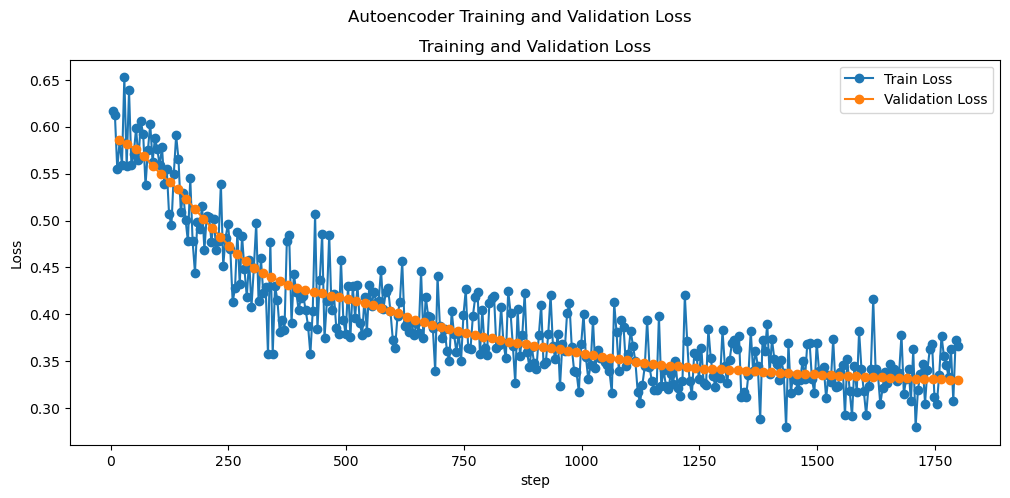

In [ ]:
history = pd.read_csv(best_model_logger.log_dir + "/metrics.csv")

make_plots(history, "Autoencoder Training and Validation Loss")